In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

/opt/anaconda3/envs/tf/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [3]:
# load data set
df = pd.read_csv('spotify_churn_dataset.csv')
df.drop(columns=['user_id'], inplace=True)  # Drop user_id as it's not a feature

In [4]:
# get idea from sample data
df.head()

,gender,age,country,subscription_type,listening_time,songs_played_per_day,skip_rate,device_type,ads_listened_per_week,offline_listening,is_churned
0,Female,54,CA,Free,26,23,0.20,Desktop,31,0,1
1,Other,33,DE,Family,141,62,0.34,Web,0,1,0
2,Male,38,AU,Premium,199,38,0.04,Mobile,0,1,1
3,Female,22,CA,Student,36,2,0.31,Mobile,0,1,0
4,Other,29,US,Family,250,57,0.36,Mobile,0,1,1


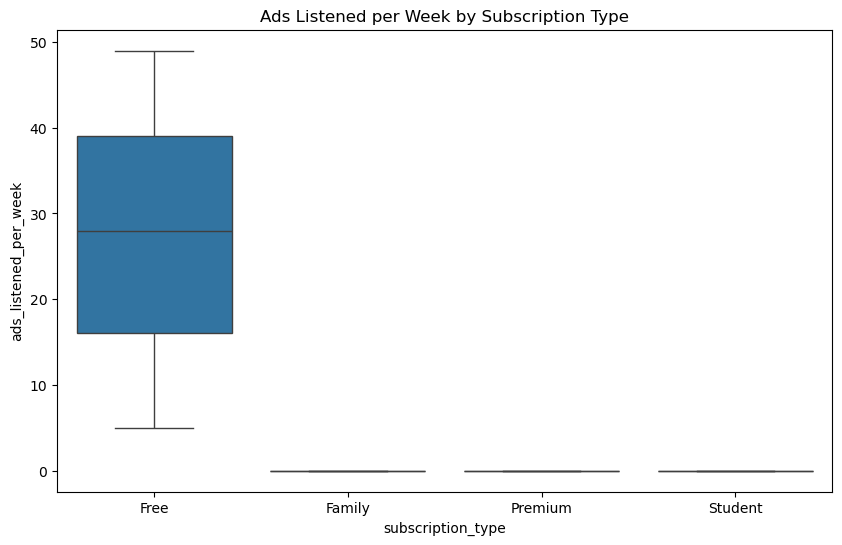

In [5]:
# see the relation between subscription_type and ads_listened_per_week
plt.figure(figsize=(10, 6))
sns.boxplot(x='subscription_type', y='ads_listened_per_week', data=df)
plt.title('Ads Listened per Week by Subscription Type')
plt.show()

In [6]:
# get idea of column names and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   gender                 8000 non-null   object 
 1   age                    8000 non-null   int64  
 2   country                8000 non-null   object 
 3   subscription_type      8000 non-null   object 
 4   listening_time         8000 non-null   int64  
 5   songs_played_per_day   8000 non-null   int64  
 6   skip_rate              8000 non-null   float64
 7   device_type            8000 non-null   object 
 8   ads_listened_per_week  8000 non-null   int64  
 9   offline_listening      8000 non-null   int64  
 10  is_churned             8000 non-null   int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 687.6+ KB


In [44]:
# All data types looks ok.

In [7]:
# know the shape of data
df.shape

(8000, 11)

In [8]:
# check for missing values
df.isnull().sum().any()

np.False_

In [9]:
# check for duplicate rows
df.duplicated().sum()

np.int64(0)

In [100]:
# no missing values or duplicate rows

In [10]:
# explore features of data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,8000.0,37.662125,12.740359,16.0,26.00,38.0,49.00,59.0
listening_time,8000.0,154.068250,84.015596,10.0,81.00,154.0,227.00,299.0
songs_played_per_day,8000.0,50.127250,28.449762,1.0,25.00,50.0,75.00,99.0
skip_rate,8000.0,0.300127,0.173594,0.0,0.15,0.3,0.45,0.6
ads_listened_per_week,8000.0,6.943875,13.617953,0.0,0.00,0.0,5.00,49.0
offline_listening,8000.0,0.747750,0.434331,0.0,0.00,1.0,1.00,1.0
is_churned,8000.0,0.258875,0.438044,0.0,0.00,0.0,1.00,1.0


In [ ]:
# observations from above description:
# - ads_listened_per_week has high std deviation and also highly skewed.

In [ ]:
# Visualize through plots
# Try
# - countplot for binary & categorical columns
# - histplot/boxplot for numerical columns (non-binary)

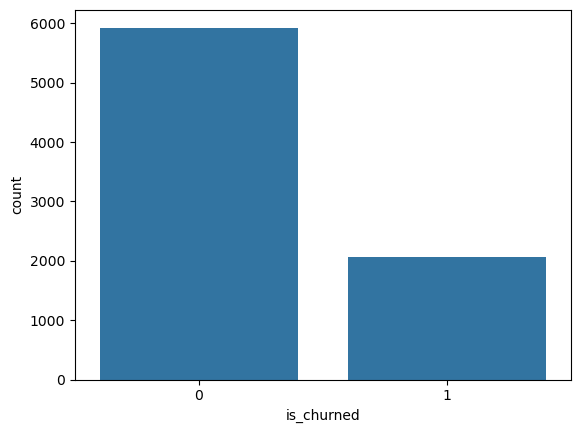

In [11]:
# Visualize the target variable distribution
sns.countplot(x='is_churned', data=df)
plt.show()

In [ ]:
'''
Interpretation:
- This may indicate class imbalance problem.
- training result may be biased towards majority class - not-churned.
- may need to stratify split during train-test split.
- may need to use techniques like oversampling/undersampling, or class weights 
to address this imbalance during model training.
- may need to use metrics like precision, recall, F1-score
to evaluate model performance effectively, rather than just accuracy due to the imbalance.
'''

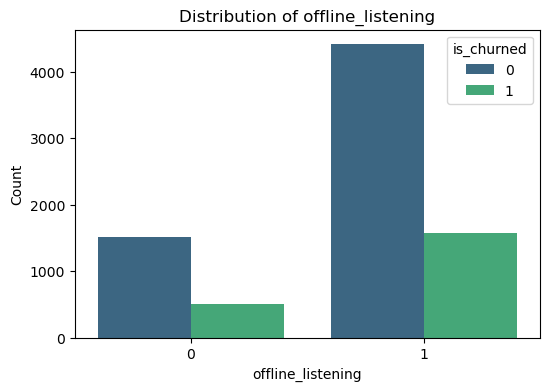

In [12]:
# count plot for binary columns
binary_cols = ['offline_listening']
for col in binary_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, data=df, hue='is_churned', palette='viridis')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()


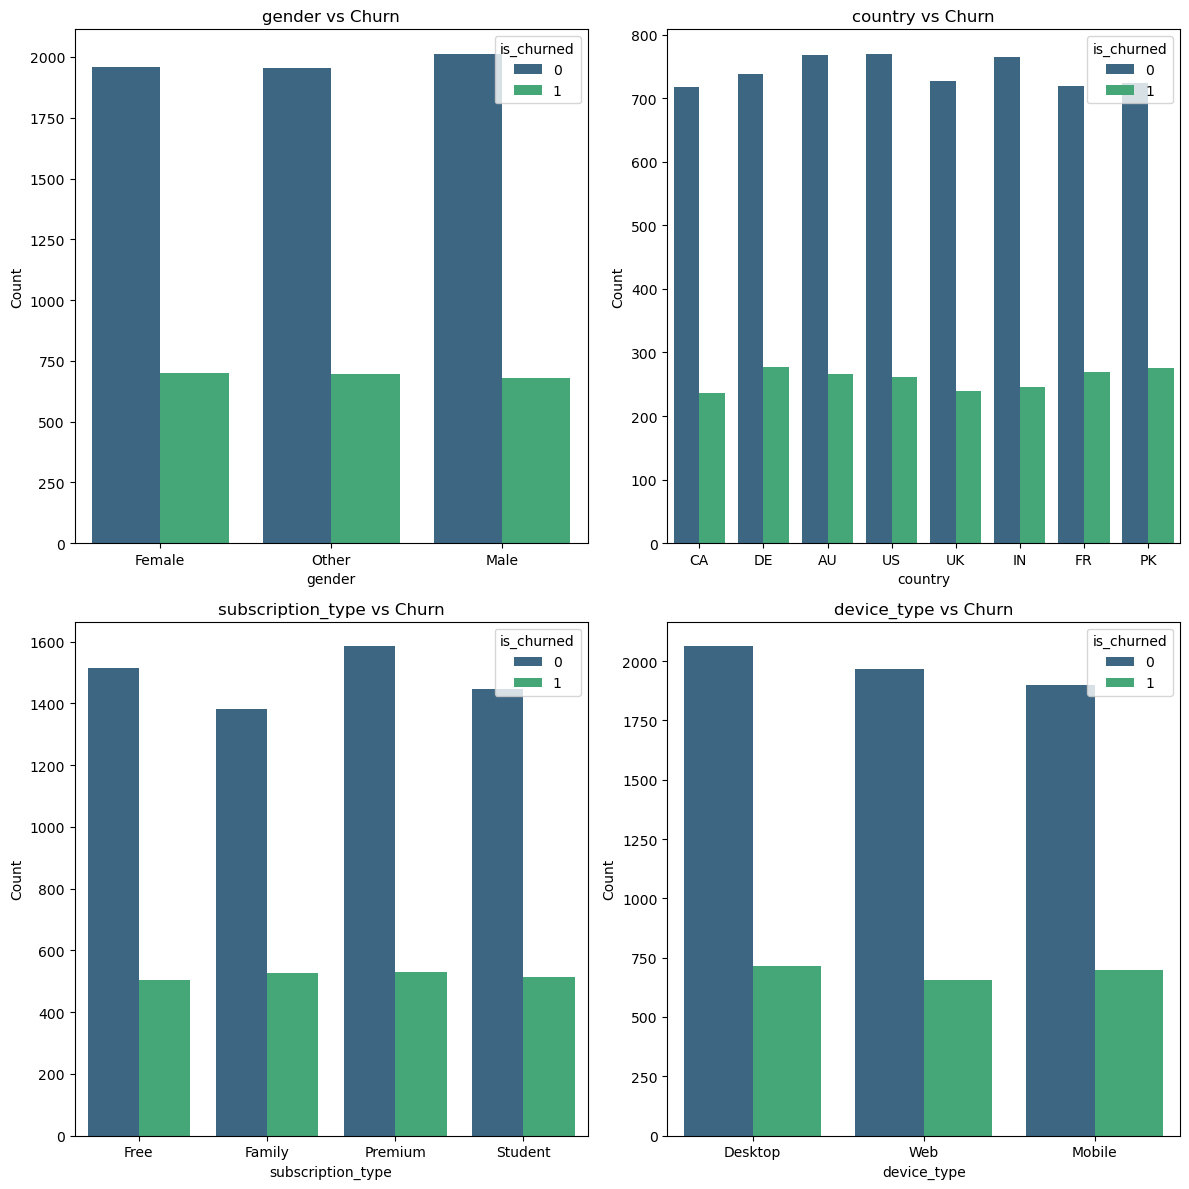

In [13]:
# count plot for categorical columns
categorical_cols = ['gender', 'country', 'subscription_type', 'device_type']
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()
for i, feature in enumerate(categorical_cols):
    sns.countplot(x=feature, hue='is_churned', data=df, palette='viridis', ax=axes[i])
    axes[i].set_title(f'{feature} vs Churn')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Count')
plt.tight_layout()
plt.show()


In [ ]:
'''Interpretation:
Due to class imbalace, all the plots show higher count for not-churned category.
'''

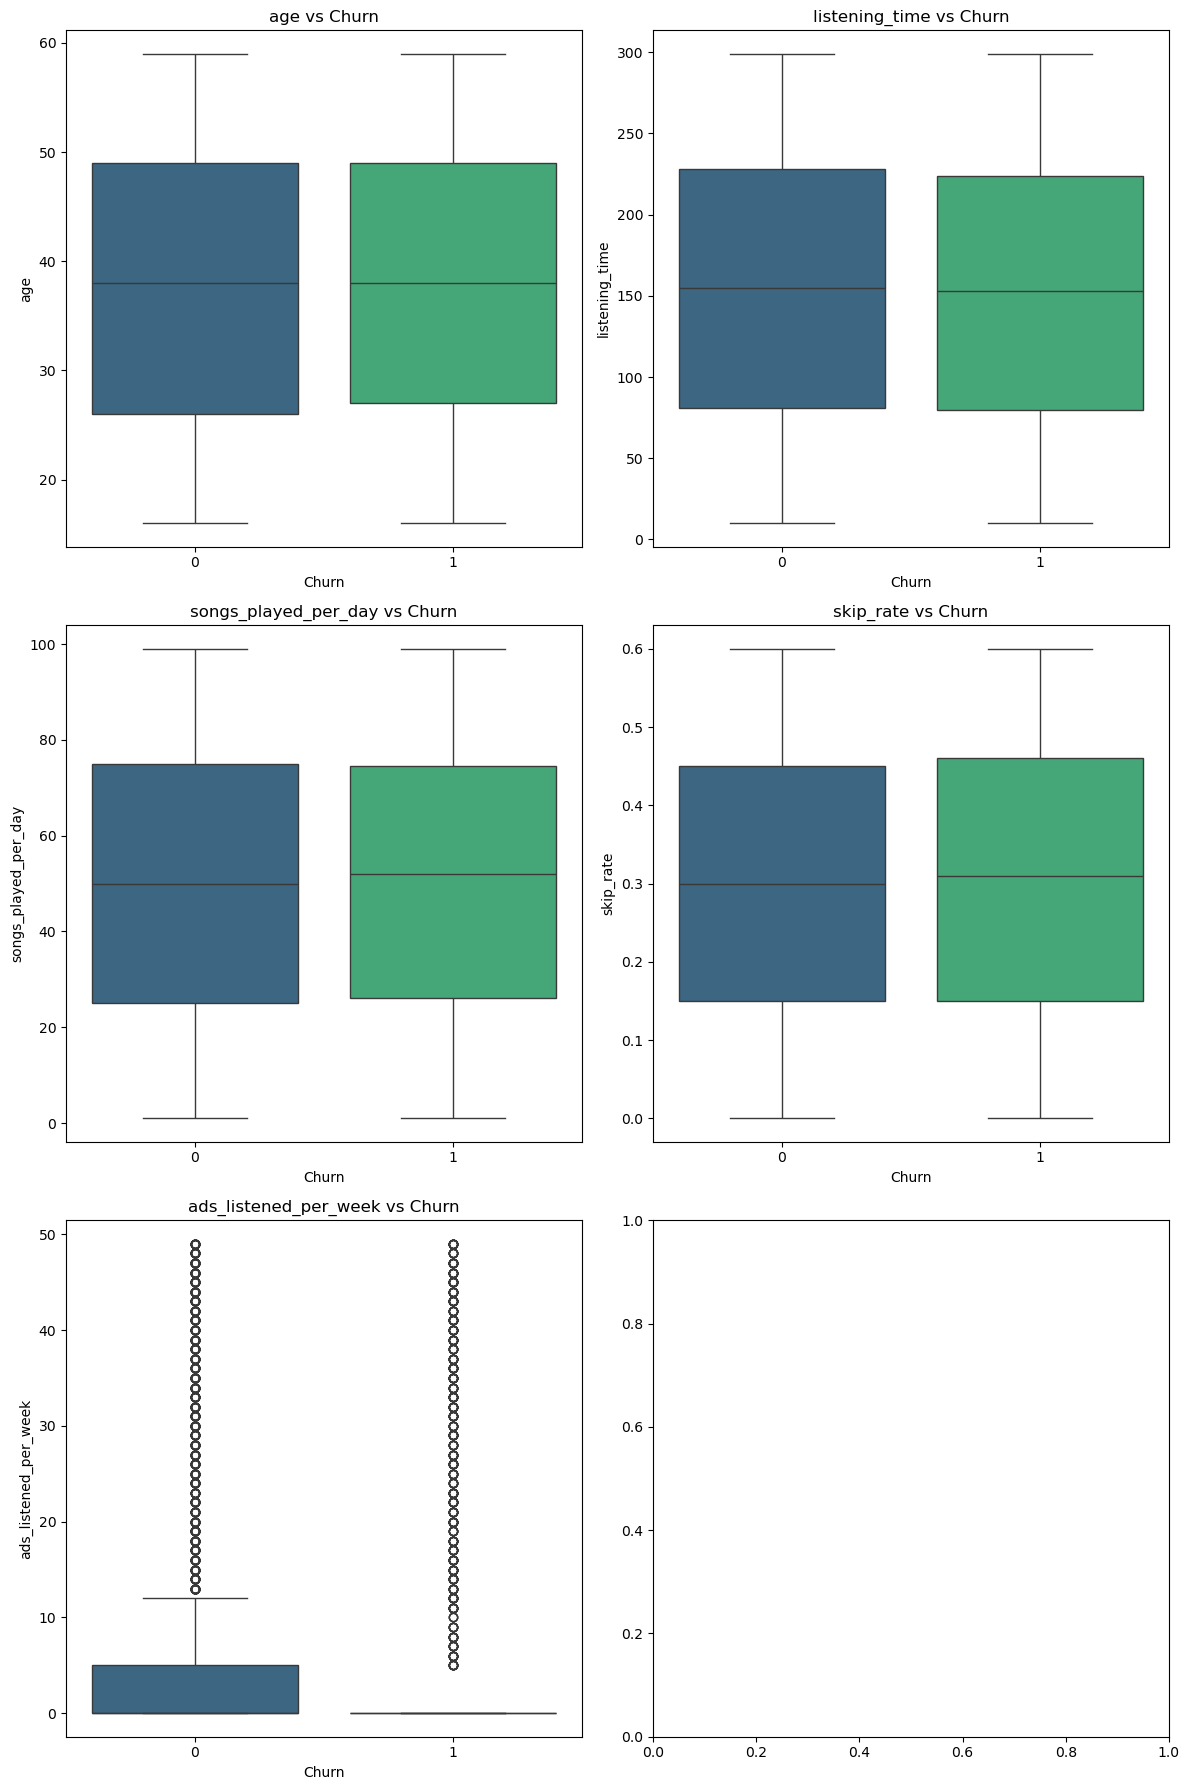

In [14]:
# Visualize box plots for numerical columns
numerical_cols = ['age', 'listening_time', 'songs_played_per_day', 'skip_rate', 'ads_listened_per_week']
fig, axes = plt.subplots(3, 2, figsize=(12, 18))
axes = axes.flatten()
for i, feature in enumerate(numerical_cols):
    sns.boxplot(x='is_churned', y=feature, data=df, palette='viridis', ax=axes[i])
    axes[i].set_title(f'{feature} vs Churn')
    axes[i].set_xlabel('Churn')
    axes[i].set_ylabel(feature)
plt.tight_layout()
plt.show()


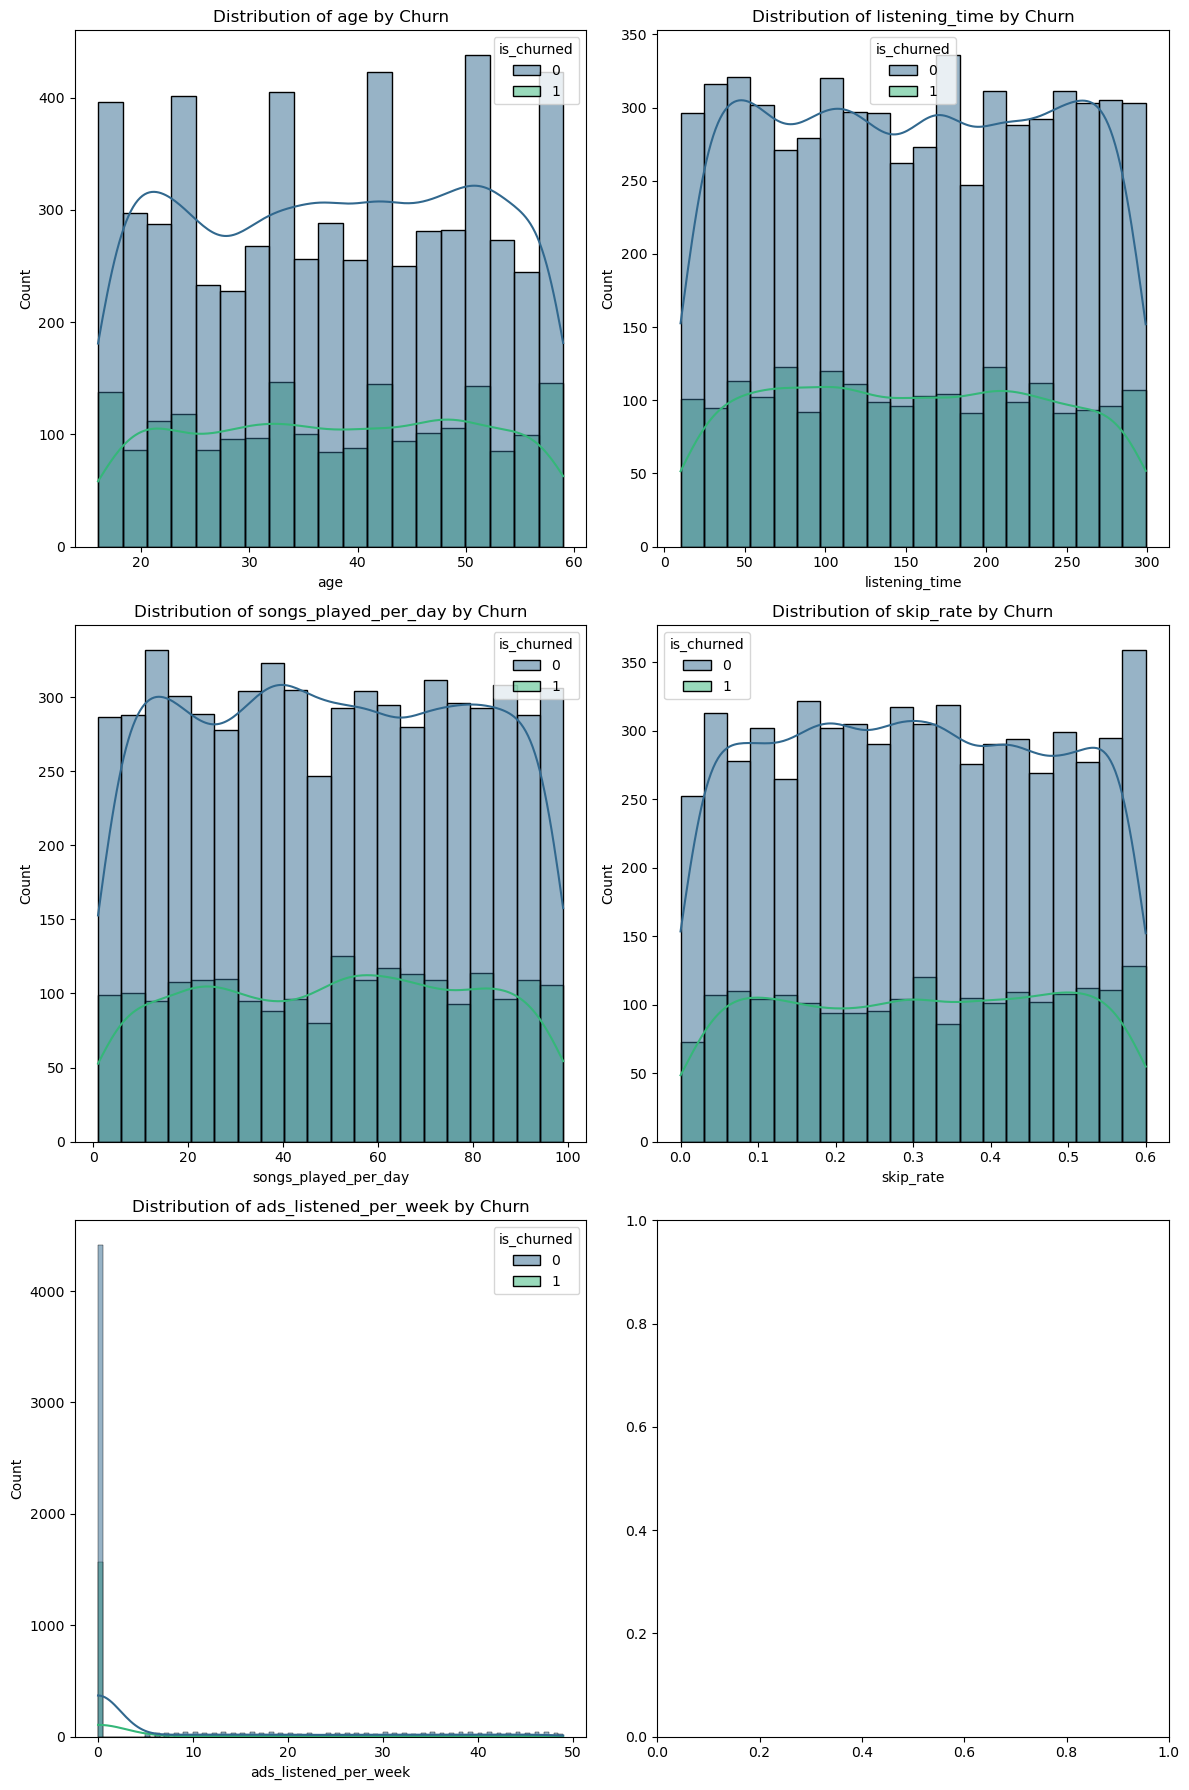

In [15]:
# plot histograms for numerical columns
fig, axes = plt.subplots(3, 2, figsize=(12, 18))
axes = axes.flatten()
for i, feature in enumerate(numerical_cols):
    sns.histplot(data=df, x=feature, hue='is_churned', kde=True, palette='viridis', ax=axes[i])
    axes[i].set_title(f'Distribution of {feature} by Churn')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Count')
plt.tight_layout()
plt.show()

In [ ]:
'''
Interpretation:
- There is no significant difference in age, listening time, songs played per day, skip rate,  
between churned and not-churned users. Non-churned data are more in all the categories.
- significant outliers are present in ads_listened_per_week feature.
- Users with more ads listened per week are less likely to be churned.
'''

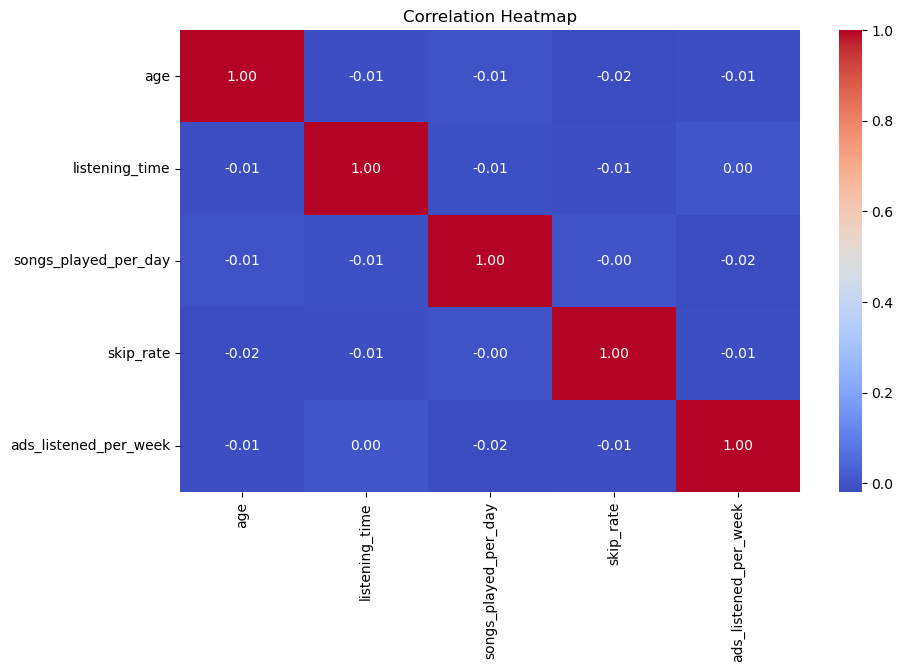

In [16]:
# visualize heatmap for correlation
plt.figure(figsize=(10, 6))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [17]:
# check for invalid values in numerical columns
for col in numerical_cols:
    if (df[col] < 0).any():
        print(f'Invalid values found in column: {col}')
    else:
        print(f'No invalid values in column: {col}')


No invalid values in column: age
No invalid values in column: listening_time
No invalid values in column: songs_played_per_day
No invalid values in column: skip_rate
No invalid values in column: ads_listened_per_week


In [18]:
# check invalid values in categorical columns
for col in categorical_cols + binary_cols:
    if df[col].isnull().any():
        print(f'Invalid values found in column: {col}')
    else:
        print(f'No invalid values in column: {col}')

No invalid values in column: gender
No invalid values in column: country
No invalid values in column: subscription_type
No invalid values in column: device_type
No invalid values in column: offline_listening


In [ ]:
# Data preprocessing

In [19]:
# separate input features and target variable
X = df.drop('is_churned', axis=1)
y = df['is_churned']

In [20]:
# classify numerical and categorical features
numerical_features = X.select_dtypes(include = ['int64', 'float64']).columns
categorical_features = X.select_dtypes(include = ['object']).columns

In [21]:
# encode categorical features and scale numerical features
preprocessor = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), numerical_features),      # Transform numerical columns
        ('cat', OneHotEncoder(drop='first'), categorical_features)  # Transform categorical columns
    ]
)

In [22]:
# transform skewed numerical feature 'ads_listened_per_week' using log transformation
X['ads_listened_per_week'] = X['ads_listened_per_week'].apply(lambda x: np.log1p(x))

In [23]:
# train split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# further split temp into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)


In [24]:
# apply preprocessor
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

'''
fit: “Learns” parameters from data.
StandardScaler learns mean and std.
OneHotEncoder learns the list/order of categories.
transform: Applies those learned parameters to new data without re-learning.

Fit anything that “learns” from data on training only; use transform for everything else.
'''

'\nfit: “Learns” parameters from data.\nStandardScaler learns mean and std.\nOneHotEncoder learns the list/order of categories.\ntransform: Applies those learned parameters to new data without re-learning.\n\nFit anything that “learns” from data on training only; use transform for everything else.\n'

In [25]:
# random forest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# create and train the model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_processed, y_train)

# make predictions
y_pred = rf_model.predict(X_val_processed)

# evaluate the model
print(classification_report(y_val, y_pred))
# print(confusion_matrix(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.99      0.85       593
           1       0.00      0.00      0.00       207

    accuracy                           0.73       800
   macro avg       0.37      0.49      0.42       800
weighted avg       0.55      0.73      0.63       800



In [ ]:
'''
Interpretation:
- Not Churned prediction:
Precision: 74% - When model predicts "not churned", it's correct 74% of the time.
Recall: 99% - Model catches almost ALL non-churned users (but this is misleading).
F1-score: 85% - Seems ok for non-churned prediction.

- Churned prediction:
Precision: 0% - Model NEVER correctly predicts churn.
Recall: 0% - Model NEVER identifies any churned users.
F1-score: 0% - Complete failure.

hence the model is completely biased towards majority class - not-churned.
'''

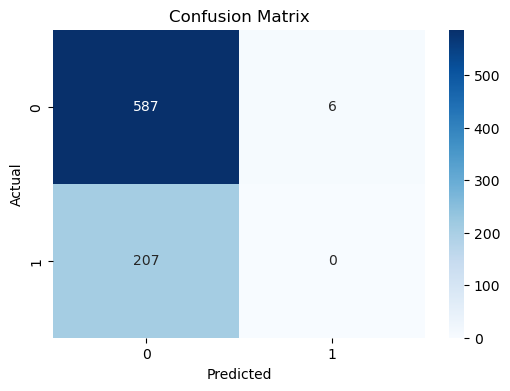

In [26]:
# confusion matrix heatmap
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
'''
Interpretation:
- Most predictions are for not-churned class and none for churned class.
- The 207 who are actually churned are all misclassified as not-churned, indicating high false negative rate.
'''

In [27]:
# print number of rows in class 0 and class 1 in actual training data
print(np.bincount(y_train))

[4743 1657]


In [28]:
# handle class imbalance using and SMOTE
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

In [29]:
# number of rows in class 0 and class 1 in resampled training data
print(np.bincount(y_train_resampled))

[4743 4743]


In [30]:
# Try applying same random forest model on resampled data
rf_model_resampled = RandomForestClassifier(random_state=42)
rf_model_resampled.fit(X_train_resampled, y_train_resampled)
y_train_pred_resampled = rf_model_resampled.predict(X_train_resampled)
y_pred_after_resampling = rf_model_resampled.predict(X_val_processed)
print(classification_report(y_val, y_pred_after_resampling))

# print training and validation accuracy, precision, recall, f1-score for resampled model
print('Training accuracy: ', np.round(metrics.accuracy_score(y_train_resampled, y_train_pred_resampled), 4))
print('Training precision: ', np.round(metrics.precision_score(y_train_resampled, y_train_pred_resampled), 4))
print('Training recall: ', np.round(metrics.recall_score(y_train_resampled, y_train_pred_resampled), 4))
print('Training f1-score: ', np.round(metrics.f1_score(y_train_resampled, y_train_pred_resampled), 4))

print('Validation accuracy: ', np.round(metrics.accuracy_score(y_val, y_pred_after_resampling), 4))
print('Validation precision: ', np.round(metrics.precision_score(y_val, y_pred_after_resampling), 4))
print('Validation recall: ', np.round(metrics.recall_score(y_val, y_pred_after_resampling), 4))
print('Validation f1-score: ', np.round(metrics.f1_score(y_val, y_pred_after_resampling), 4))

              precision    recall  f1-score   support

           0       0.74      0.92      0.82       593
           1       0.29      0.09      0.14       207

    accuracy                           0.71       800
   macro avg       0.52      0.51      0.48       800
weighted avg       0.63      0.71      0.65       800

Training accuracy:  1.0
Training precision:  1.0
Training recall:  1.0
Training f1-score:  1.0
Validation accuracy:  0.7075
Validation precision:  0.2923
Validation recall:  0.0918
Validation f1-score:  0.1397


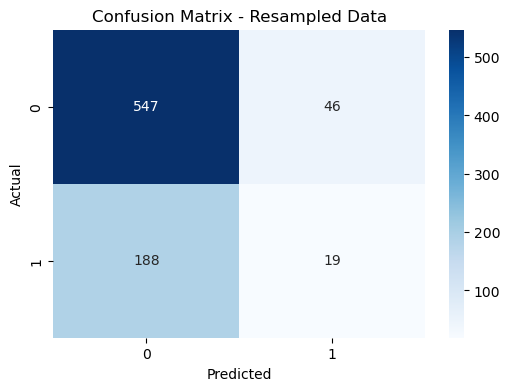

In [31]:
# confusion matrix heatmap for resampled model
cm_resampled = confusion_matrix(y_val, y_pred_after_resampling)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_resampled, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Resampled Data')
plt.show()

In [ ]:
'''
Interpretation:
- Model has started to predict some churned users, but still struggles with false negatives.
- Only 9% recall - missing 91% of churned users.
- Precision for churned class is 29% - when it predicts churn, it's correct only 29% of the time.
'''

In [32]:
# hyperparameter tuning
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf_model_2 = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_model_2, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train_resampled, y_train_resampled)
best_rf_model = grid_search.best_estimator_
y_pred_best = best_rf_model.predict(X_val_processed)
print(classification_report(y_val, y_pred_best))

Fitting 3 folds for each of 24 candidates, totalling 72 fits


/opt/anaconda3/envs/tf/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/opt/anaconda3/envs/tf/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/opt/anaconda3/envs/tf/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/opt/anaconda3/envs/tf/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/opt/anaconda3/envs/tf/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection depend

              precision    recall  f1-score   support

           0       0.74      0.91      0.82       593
           1       0.28      0.10      0.14       207

    accuracy                           0.70       800
   macro avg       0.51      0.51      0.48       800
weighted avg       0.62      0.70      0.65       800



In [33]:
best_rf_model

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
# no improvement even after hyperparameter tuning.

In [34]:
# Basic Neural Network model

# Model with 2 hidden layers
model1 = Sequential([
    Dense(32, activation = 'relu', input_shape = (X_train_processed.shape[1],)),  # Hidden Layer 1
    Dense(16, activation = 'relu'),                                # Hidden Layer 2
    Dense(1, activation = 'sigmoid')                               # Output Layer
])

In [35]:
# Compile the model
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'recall'])

In [36]:
# Fit the model
early_stopping1 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
result1 = model1.fit(
    X_train_resampled, y_train_resampled,
    validation_data = (X_val_processed, y_val),
    epochs = 50,
    callbacks = [early_stopping1],
    batch_size = 32,
    verbose = 1
)

Epoch 1/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 872us/step - accuracy: 0.5096 - loss: 0.6947 - recall: 0.4896 - val_accuracy: 0.5200 - val_loss: 0.6918 - val_recall: 0.4541
Epoch 2/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - accuracy: 0.5434 - loss: 0.6867 - recall: 0.5203 - val_accuracy: 0.6012 - val_loss: 0.6710 - val_recall: 0.2367
Epoch 3/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - accuracy: 0.5636 - loss: 0.6817 - recall: 0.5319 - val_accuracy: 0.5512 - val_loss: 0.6840 - val_recall: 0.3865
Epoch 4/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - accuracy: 0.5701 - loss: 0.6773 - recall: 0.5488 - val_accuracy: 0.5775 - val_loss: 0.6727 - val_recall: 0.3430
Epoch 5/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - accuracy: 0.5852 - loss: 0.6711 - recall: 0.5488 - val_accuracy: 0.4812 - val_loss: 0.7121 - val_recall: 0.5459
Epoch 6/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - accuracy: 0.5945 - loss: 0.6651 - recall: 0.5794 - val_accuracy: 0.4787 - val_loss: 0.7170 - val_recall:

In [88]:
# Validation results are still lagging behind training results, indicating overfitting.

In [37]:
# Model with 3 hidden layers
model2 = Sequential([
    Dense(64, activation = 'relu', input_shape = (X_train_processed.shape[1],)),  # Hidden Layer 1
    Dropout(0.2),
    Dense(32, activation = 'relu'),                                # Hidden Layer 2
    Dropout(0.2),
    Dense(16, activation = 'relu'),                                # Hidden Layer 3
    Dropout(0.2),
    Dense(1, activation = 'sigmoid')                               # Output Layer
])
# Compile the model
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'recall', 'precision'])
# Fit the model
early_stopping2 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
result2 = model2.fit(
    X_train_resampled, y_train_resampled,
    validation_data = (X_val_processed, y_val),
    epochs = 50,
    callbacks = [early_stopping2],
    batch_size = 32,
    verbose = 1
)

Epoch 1/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5113 - loss: 0.6943 - precision: 0.5127 - recall: 0.4537 - val_accuracy: 0.5188 - val_loss: 0.6937 - val_precision: 0.2658 - val_recall: 0.4879
Epoch 2/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.5251 - loss: 0.6914 - precision: 0.5303 - recall: 0.4385 - val_accuracy: 0.4650 - val_loss: 0.7002 - val_precision: 0.2683 - val_recall: 0.6184
Epoch 3/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - accuracy: 0.5375 - loss: 0.6886 - precision: 0.5388 - recall: 0.5206 - val_accuracy: 0.4512 - val_loss: 0.7033 - val_precision: 0.2593 - val_recall: 0.6039
Epoch 4/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - accuracy: 0.5453 - loss: 0.6861 - precision: 0.5457 - recall: 0.5414 - val_accuracy: 0.5550 - val_loss: 0.6836 - val_precision: 0.2573 - val_recall: 0.3816
Epoch 5/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - accuracy: 0.5598 - loss: 0.6825 - precision: 0.5631 - recall: 0.5334 - val_accuracy: 0.4688 - val_

In [38]:
# Model with more hidden layers
model3 = Sequential([
    Dense(256, activation = 'relu', input_shape = (X_train_processed.shape[1],)),  # Hidden Layer 1
    Dropout(0.5),
    Dense(128, activation = 'relu'),                                # Hidden Layer 2
    Dropout(0.5),
    Dense(64, activation = 'relu'),                                # Hidden Layer 3
    Dropout(0.5),
    Dense(32, activation = 'relu'),                                # Hidden Layer 4
    Dropout(0.5),
    Dense(16, activation = 'relu'),                                # Hidden Layer 5
    Dropout(0.5),
    Dense(1, activation = 'sigmoid')                               # Output Layer
])
# Compile the model
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'recall', 'precision', 
                                                                      tf.keras.metrics.AUC(curve='ROC', name='auc'),])
# Fit the model
early_stopping3 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
result3 = model3.fit(
    X_train_resampled, y_train_resampled,
    validation_data = (X_val_processed, y_val),
    epochs = 100,
    # callbacks = [early_stopping3],
    batch_size = 32,
    verbose = 1
)

Epoch 1/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4950 - auc: 0.4946 - loss: 0.7005 - precision: 0.4949 - recall: 0.4778 - val_accuracy: 0.4087 - val_auc: 0.5102 - val_loss: 0.6938 - val_precision: 0.2746 - val_recall: 0.7826
Epoch 2/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step - accuracy: 0.5022 - auc: 0.4968 - loss: 0.6942 - precision: 0.5021 - recall: 0.5210 - val_accuracy: 0.2587 - val_auc: 0.4995 - val_loss: 0.6980 - val_precision: 0.2587 - val_recall: 1.0000
Epoch 3/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - accuracy: 0.5030 - auc: 0.5035 - loss: 0.6934 - precision: 0.5025 - recall: 0.5935 - val_accuracy: 0.2587 - val_auc: 0.5030 - val_loss: 0.6988 - val_precision: 0.2587 - val_recall: 1.0000
Epoch 4/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - accuracy: 0.5058 - auc: 0.5032 - loss: 0.6936 - precision: 0.5048 - recall: 0.6100 - val_accuracy: 0.2587 - val_auc: 0.5086 - val_loss: 0.7018 - val_precision: 0.2587 - val_recall: 1.0000
Epoch 5/100
297/297 ━━

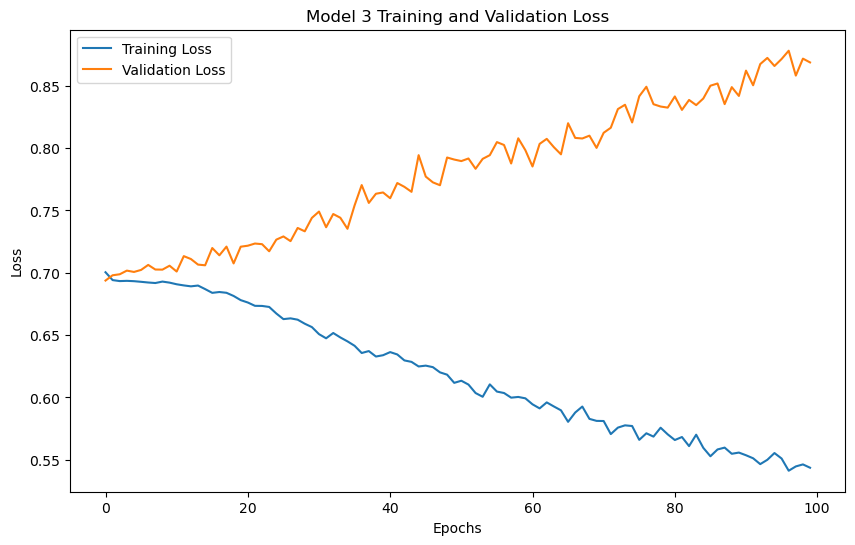

In [39]:
# plot training and validation loss for model3
plt.figure(figsize=(10, 6))
plt.plot(result3.history['loss'], label='Training Loss')
plt.plot(result3.history['val_loss'], label='Validation Loss')
plt.title('Model 3 Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [41]:
# compare validation accuracy, precision, recall, f1-score for model 3 and random forest model
y_val_pred_model3 = (model3.predict(X_val_processed) > 0.5).astype("int32")
print("ANN Model Validation Classification Report:")
print(classification_report(y_val, y_val_pred_model3))

y_val_pred_rf = (rf_model.predict(X_val_processed) > 0.5).astype("int32")
print("Random Forest Validation Classification Report:")
print(classification_report(y_val, y_val_pred_rf))

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step
ANN Model Validation Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.35      0.47       593
           1       0.25      0.62      0.36       207

    accuracy                           0.42       800
   macro avg       0.49      0.49      0.41       800
weighted avg       0.60      0.42      0.44       800

Random Forest Validation Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.99      0.85       593
           1       0.00      0.00      0.00       207

    accuracy                           0.73       800
   macro avg       0.37      0.49      0.42       800
weighted avg       0.55      0.73      0.63       800



In [42]:
# Saving the model and estimator
import pickle
model3.save('spotify_churn_best_ann_model.h5')
with open('preprocessor.pkl', 'wb') as f:
  pickle.dump(preprocessor, f)